In [1]:
# Imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import os
from src.utils.preprocess_utils import midi_to_multiclass_vectors
from src.utils.ml_utils import create_dataloaders, train_model, test_model, plot_metrics
import math

In [2]:
# Define dataset
class MidiDataset(Dataset):
    def __init__(self, data_dir, sequence_length=50, tick_resolution=50):
        self.data_dir = data_dir
        self.sequence_length = sequence_length
        self.tick_resolution = tick_resolution
        self.file_names = [f for f in os.listdir(data_dir) if f.endswith('.mid') or f.endswith('.midi')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = os.path.join(self.data_dir, file_name)
        
        try:
            data = midi_to_multiclass_vectors(file_path, tick_resolution=self.tick_resolution)
            
            if len(data) < self.sequence_length:
                raise ValueError(f"File {file_name} is too short for sequence length {self.sequence_length}")
            
            # Pick a random starting index and crop the data to sequence_length
            start_idx = np.random.randint(0, len(data) - self.sequence_length + 1)
            cropped_data = data[start_idx:start_idx + self.sequence_length]

            x = np.array(cropped_data[:-1]) # Input
            y = np.array(cropped_data[1:]) # "Label"

            return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
            # If the file is invalid or too short, retry with another random file
            new_idx = np.random.randint(0, len(self.file_names))
            return self.__getitem__(new_idx)

dataset_sequence_length = 50
tick_resolution = 400
dataset = MidiDataset(data_dir='data/midis', sequence_length=dataset_sequence_length, tick_resolution=tick_resolution)

In [3]:
# Get dataloaders with specified params from ml_utils
dataloader_train, dataloader_val, dataloader_test = create_dataloaders(dataset=dataset, batch_size=32, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, shuffle=True)

In [4]:
# Source: https://medium.com/@bavalpreetsinghh/transformer-from-scratch-using-pytorch-28a5d1b2e033
# https://towardsdatascience.com/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1) # (seq_len, 1)
        # Create a vector of shape (d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # (d_model / 2)
        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term) # sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term) # cos(position * (10000 ** (2i / d_model))
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        # Register the positional encoding as a buffer
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) # (batch, seq_len, d_model)
        return self.dropout(x)

In [5]:
# Define model architecture
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_heads, hidden_size, num_layers, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.linear_in = nn.Linear(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(d_model=embedding_size, seq_len=400, dropout=dropout)

        self.transformer = nn.Transformer(
            d_model=embedding_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )

        self.linear_out = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, src, tgt):
        # src: [batch_size, sequence_length-1, vocab_size]
        # tgt: [batch_size, sequence_length-1, vocab_size]

        src_embedded = self.linear_in(src)  # [batch_size, seq_len, embedding_size]
        tgt_embedded = self.linear_in(tgt)  # [batch_size, seq_len, embedding_size]

        src_encoded = self.positional_encoding(src_embedded)  # [batch_size, seq_len, embedding_size]
        tgt_encoded = self.positional_encoding(tgt_embedded)  # [batch_size, seq_len, embedding_size]

        seq_len = tgt.size(1)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(tgt.device)  # [seq_len, seq_len]

        transformer_output = self.transformer(src_encoded, tgt_encoded, tgt_mask=tgt_mask)  # [batch_size, sequence_length-1, vocab_size]

        output = self.linear_out(transformer_output) # [batch_size, seq_len, vocab_size]

        return output

vocab_size = 85  # Number of possible notes
embedding_size = 64 # Embedding size
num_heads = 4  # Number of attention heads
hidden_size = 128  # Size of feedforward layers in transformer
num_layers = 3  # Number of transformer encoder layers
dropout = 0.2  # Dropout rate

model = TransformerModel(vocab_size, embedding_size, num_heads, hidden_size, num_layers, dropout)

Error processing Lynes, Frank, Bagatelles, Op.14, 2pPWnuLyHKs.mid: File Lynes, Frank, Bagatelles, Op.14, 2pPWnuLyHKs.mid is too short for sequence length 50
Error processing Spindler, Fritz, Reiterlied, Op.38, 4IOer3zl6sM.mid: File Spindler, Fritz, Reiterlied, Op.38, 4IOer3zl6sM.mid is too short for sequence length 50
Error processing Bach, Carl Philipp Emanuel, Fantasia in D minor, H.224, U7Qg11-Rlug.mid: File Bach, Carl Philipp Emanuel, Fantasia in D minor, H.224, U7Qg11-Rlug.mid is too short for sequence length 50
Error processing Schubert, Franz, Ecossaise in D major, D.782, SIlfmpW_N80.mid: File Schubert, Franz, Ecossaise in D major, D.782, SIlfmpW_N80.mid is too short for sequence length 50
Error processing Baclay, George, Allegro in G major, YXRmD0H3XVU.mid: File Baclay, George, Allegro in G major, YXRmD0H3XVU.mid is too short for sequence length 50
Error processing Reichardt, Johann Friedrich, Alles, was Odem hat, eDfQi5w_L-E.mid: File Reichardt, Johann Friedrich, Alles, was Od

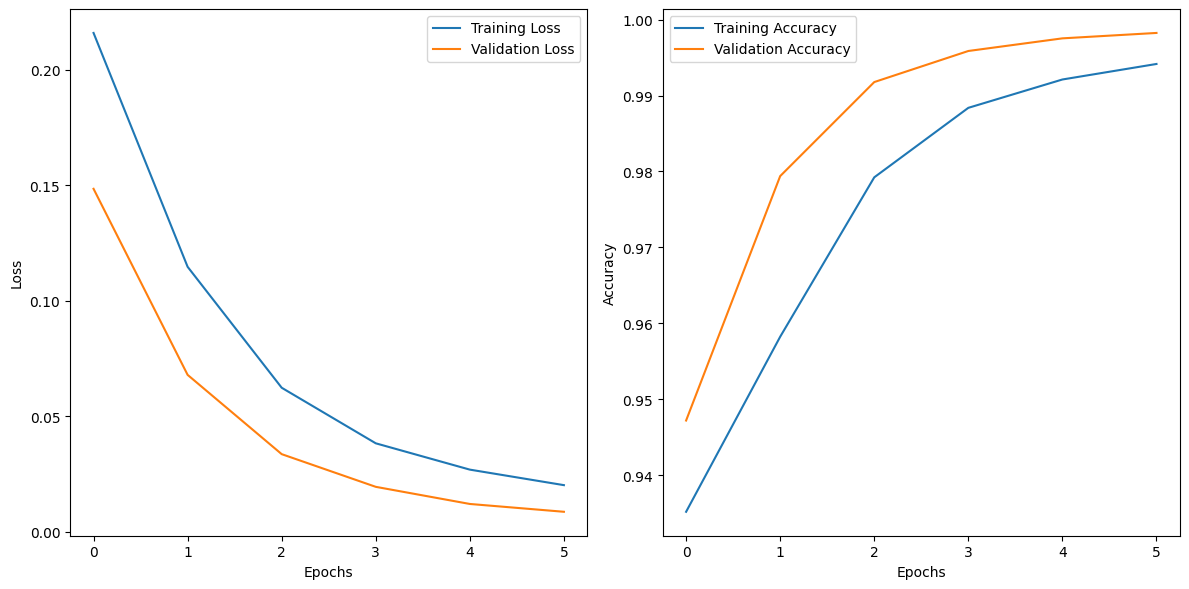

In [6]:
# Train model from ml_utils
best_model, history = train_model(
    model=model,
    dataloaders={"train": dataloader_train, "val": dataloader_val},
    task_type="multi-label",
    n_epochs=6,
    learning_rate=0.001,
    device="cuda",
    is_model_transformer=True
)
(train_losses, val_losses, train_accuracy, val_accuracy) = history
plot_metrics(train_losses, val_losses, train_accuracy, val_accuracy)

In [7]:
# Test model from ml_utils
test_model(best_model, dataloader_test, nn.BCEWithLogitsLoss(), task_type="multi-label", device="cuda", is_model_transformer=True)

Error processing Schubert, Franz, 8 Ecossaises, D.529, jFN1prco1Sg.mid: File Schubert, Franz, 8 Ecossaises, D.529, jFN1prco1Sg.mid is too short for sequence length 50
Error processing Bach, Carl Philipp Emanuel, Fantasia in D minor, H.195, nCBfeqDlKb0.mid: File Bach, Carl Philipp Emanuel, Fantasia in D minor, H.195, nCBfeqDlKb0.mid is too short for sequence length 50
Error processing Schubert, Franz, Ecossaise, D.158, b34nNxbBBBY.mid: File Schubert, Franz, Ecossaise, D.158, b34nNxbBBBY.mid is too short for sequence length 50
Test metrics - Loss: 0.0088, Accuracy: 0.9981


(np.float64(0.008833599605542771), np.float64(0.9981251499232124))

In [8]:
# Save model
from datetime import datetime

timestamp = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'weights/model_6/{timestamp}_e{embedding_size}_nh{num_heads}_h{hidden_size}_l{num_layers}_sl{dataset_sequence_length}_tr{tick_resolution}'

torch.save(best_model, filename)